# Lab 5 Report

Seth Richards and Anup Paudel

In [236]:
# import cell

import numpy as np
from scipy.io import wavfile as wav
import simpleaudio as sa
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

## Summary

In this lab, we make use of several numpy functions related to the Fast Fourier Transform to transform basic sinusoidal functions. Using threshold values, we then find the peaks of the fft to get the frequency components of the original signal. We show the graph of the frequencies with and without noise to show the necessity of the threshold. We then turn that process into a function, and use it to find the frequency components of several new functions related to certain phone number digits. Then, we transcribe a given set of functions to find their corresponding phone numbers to demonstrate our proficiency.

## Assignment 1: Identifying Constituent Frequencies of a Signal

In [245]:
#A1

fs = 8000
t = np.arange(0, 0.25, 1/fs)
d0 = np.sin(2*np.pi*941*t) + np.sin(2*np.pi*1336*t)

pause = np.zeros(int(2*fs)) # 2 second buffer
d0 = np.concatenate([d0, pause, d0])  * 100
wav.write('d0.wav',fs,d0.astype('int16'))

In [212]:
# plays telephone tone "0"
fs,d0 = wav.read("d0.wav")
play_obj =sa.play_buffer(d0, 1, 2, fs)
play_obj.wait_done()

In [249]:
xf = np.fft.fft(d0/100,fs) # FFT of time signal x, nfft frequency samples
xfs = np.fft.fftshift(xf) # shift FFT of xf to be centered around 0

d0ft  = np.abs(xfs)
f = np.arange(-fs/2,fs/2,1)

#Mask to find peak frequencies

ind = np.arange(len(d0ft))
peaks = ind[d0ft[ind] > 900]
peaks = peaks - 4000
print("Frequencies",peaks[peaks>0])

Frequencies [ 941 1336]


In [247]:
n = np.random.normal(0,1,len(d0))

d0n = d0/100 + n

xfn = np.fft.fft(d0n,8000) # FFT of time signal x, nfft frequency samples
xfsn = np.fft.fftshift(xfn) # shift FFT of xf to be centered around 0

d0nft  = np.abs(xfsn)

<IPython.core.display.Javascript object>


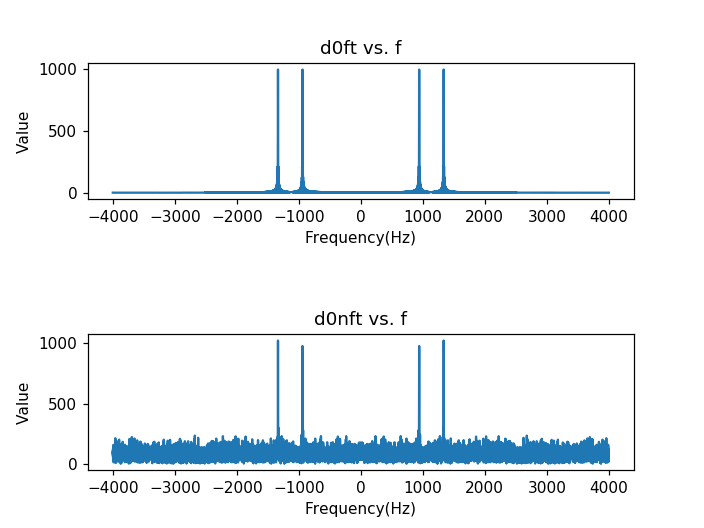

Text(0, 0.5, 'Value')

In [248]:
fig1 = plt.figure(1)
fig1.subplots_adjust(hspace=1,wspace=0.4)

plt.subplot(2,1,1)
plt.title('d0ft vs. f')
plt.plot(f,d0ft)
plt.xlabel('Frequency(Hz)')
plt.ylabel('Value')
plt.subplot(2,1,2)
plt.title('d0nft vs. f')
plt.plot(f,d0nft)
plt.xlabel('Frequency(Hz)')
plt.ylabel('Value')

### Discussion

A threshold of 100 would not work because some of the noise is larger than 100, meaning the threshold check would return more frequencies than the desired actual frequencies. The threshold needs to be high enough that we can be confident that the frequency components are much larger in the fft than the other values.

That threshold would identify more frequencies that the thresh = 900.

Noise adds lots of values in between true peaks, making the threshold necessary.

If the signal had added 1, the fft would look like it has an additional peak at 0, since the fourier transform of 1 is e^j0t.

## Assignment 2 : Classifying Touch-Tone Telephone Signals

In [140]:
#A2

# method takes signal x and sampling frequency fs and returns closet related 
# phone digit by finding frequency components of x
def classify(x,fs):

    pause = np.zeros(int(2*fs)) # 2 second buffer
    x = np.concatenate([x, pause, x])  * 1000
    
    N = 4096
    spacing = fs/N
    xf = np.fft.fft(x,N) # FFT of time signal x, nfft frequency samples
    xfft_abs = np.abs(np.fft.fftshift(xf/100)) # shift FFT of xf to be centered around 0

    ind = np.arange(0,len(xfft_abs),1)
    peaks = ind[xfft_abs[ind] > 9000]
    index_tone = peaks*spacing - fs/2
    
    freq_tone = index_tone[index_tone>0]
    pos_freq = np.absolute(freq_tone)
    pos_freq = np.around(pos_freq)
    
    # Phone Number Frequencies
    #                          0            1          2         3          4           5         6          7          8           9
    tone_freqs = np.array([[941,1336], [697,1209],[697,1336],[697,1477],[770,1209],[770,1336],[770,1477],[852,1209],[852,1336],[852,1477]])
    digit_error = np.zeros(10)
    
    for i in range(10):
        
        digit_error[i] = ((pos_freq[0] - tone_freqs[i,0])**2) + ((pos_freq[1] - tone_freqs[i,1])**2)
    
    min_e_tone = np.argmin(digit_error) 
    return min_e_tone 

In [250]:
fs = 8000
t = np.arange(0, 0.25, 1/fs1)
d4 = np.sin(2*np.pi*770*t1) + np.sin(2*np.pi*1209*t1)
d5 = np.sin(2*np.pi*770*t1) + np.sin(2*np.pi*1336*t1)
d8 = np.sin(2*np.pi*852*t1) + np.sin(2*np.pi*1336*t1)
d9 = np.sin(2*np.pi*852*t1) + np.sin(2*np.pi*1477*t1)

print("Below shows the classify method functions as expected:")
print("d4 returns",classify(d4,fs))
print("d5 returns",classify(d5,fs))
print("d8 returns",classify(d8,fs))
print("d9 returns",classify(d9,fs))

Below shows the classify method functions as expected:
d4 returns 4
d5 returns 5
d8 returns 8
d9 returns 9


### Discussion

If the signal had noise, we could compensate by doing some rounding(like we already have in the file), and the error squared part of the function should account for slight differences in calculated frequency peaks.

The Nyquist Sampling Theorem states that: A bandlimited continuous-time signal can be sampled and perfectly reconstructed from its samples if the waveform is sampled over twice as fast as it's highest frequency component.
-UCSD Music

Xtreme ends at fs/2 because x is not sampled over twice as fast as it's highest frequency component.

## Assignment 3 : Decoding a Phone Number from Touch-Tone Signals

In [142]:
#A3

file = open('phonenum.csv','rb')
phoneCSVData = np.loadtxt(file, delimiter=',')

In [183]:
fs1 = 8000
orderedData = np.zeros([11,4000])
for i in range(11):
    lower = 0 + 4000 * i
    upper = 4000 + 4000 * i
    orderedData[i] = phoneCSVData[lower:upper]

phone_num = np.ones(11) * -1
    
for i in range(11):
    
    phone_num[i] = classify(orderedData[i,:],fs1)

print(phone_num)

[1. 8. 0. 0. 7. 8. 6. 1. 0. 0. 0.]


### Discussion

1-800-786-1000
This phone number is apparently the number for In-N-Out Burger. Cool.